## Import dataset

In [51]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


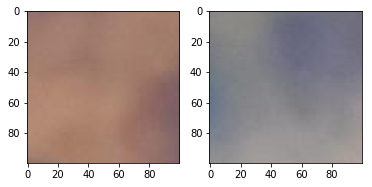

In [52]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

### add all three channels to form "grayscale" images

In [53]:
def add_3_channel(X):
    new = []
    for image in X:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        add = r+g+b
        new.append(add)
    return np.array(new)

In [54]:
X_train = add_3_channel(X_train)
X_val = add_3_channel(X_val)

### simulate microscope

In [55]:
# cast as a float32:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [56]:
wavelength = .5
thickness = 1 * wavelength

def convert_dataset(X, wavelength, thickness):
    X1 = X / np.max(X)
    X2 = np.exp(1j * X1 * thickness / wavelength)
    return X2

X_train = convert_dataset(X_train, wavelength, thickness)
X_val = convert_dataset(X_val, wavelength, thickness)

In [57]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 100, 100], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [58]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = False 

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.Variable(tf.random_uniform([100,100]),dtype=np.float32,trainable=train_illumination)
input_illumination_phase = tf.cast(input_illumination_phase, tf.complex64)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*input_illumination_phase)

In [59]:
# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = X_batch * input_illumination
aperture_plane = tf.fft2d(emerging_field)

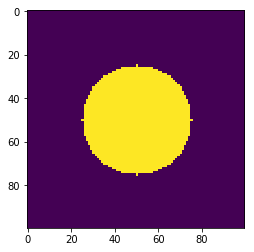

In [60]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
r = 0.25*100
circ_aper = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        if (i-50)**2+(j-50)**2 <= r**2:
            circ_aper[i,j] = 1

plt.imshow(circ_aper)
circ_aper = np.fft.fftshift(circ_aper)

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.Variable(tf.random_uniform([100,100]),dtype=np.float32)
aperture_phase = tf.cast(aperture_phase, tf.complex64)

# write the full aperture function, combining the above two components:
aperture = circ_aper * tf.exp(1j * aperture_phase)

# filter the field that you propagated:
aperture_plane_filtered = aperture_plane * aperture

In [61]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = (tf.abs(tf.ifft2d(aperture_plane_filtered)))**2
#image = tf.abs(tf_fftshift2(tf.fft2d(tf_ifftshift2(aperture_plane_filtered))))**2

# add noise:
#image += tf.random_normal([100,100],stddev=0.05)

In [62]:
net = image[..., None]  # add a channels dimension

# define your CNN here

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=10)

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.00001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [63]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

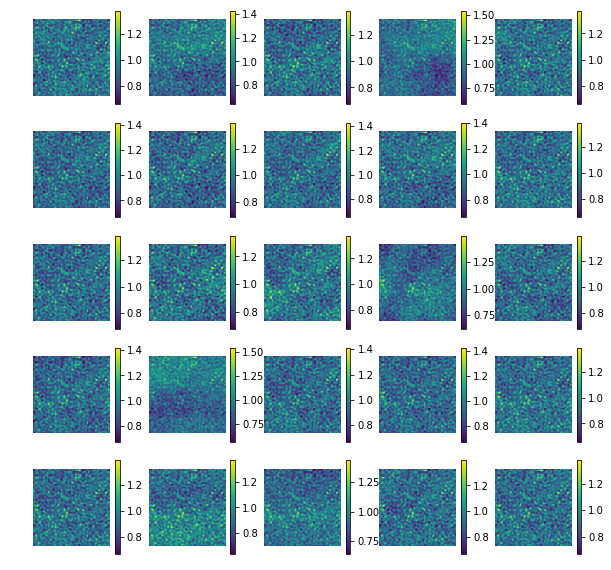

In [64]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [65]:
# train loop:
correct = 0
total = 0
for i in range(10000):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)

2.2135668
1.6166394
0.9278208
0.78111345
0.71266353
0.6855648
0.7227619
0.72746706
0.7129699
0.7095226
Accuracy is:
0.5714187129073137


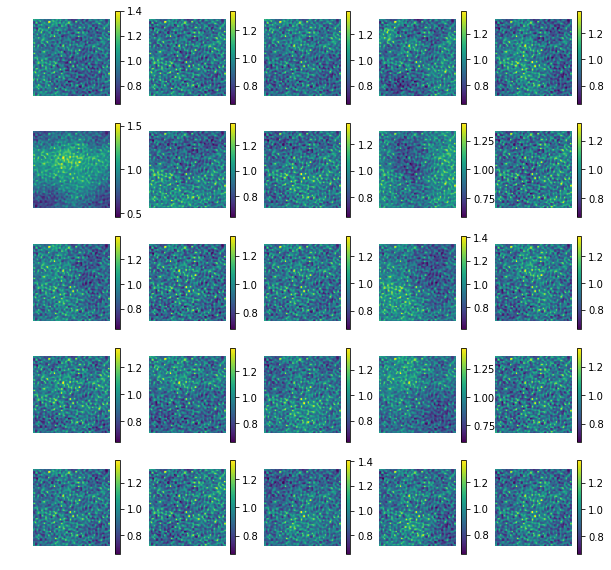

In [47]:
# plot examples 
plot_examples(image.eval())

In [66]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)

Test accuracy is:
0.5342071611253197
